In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


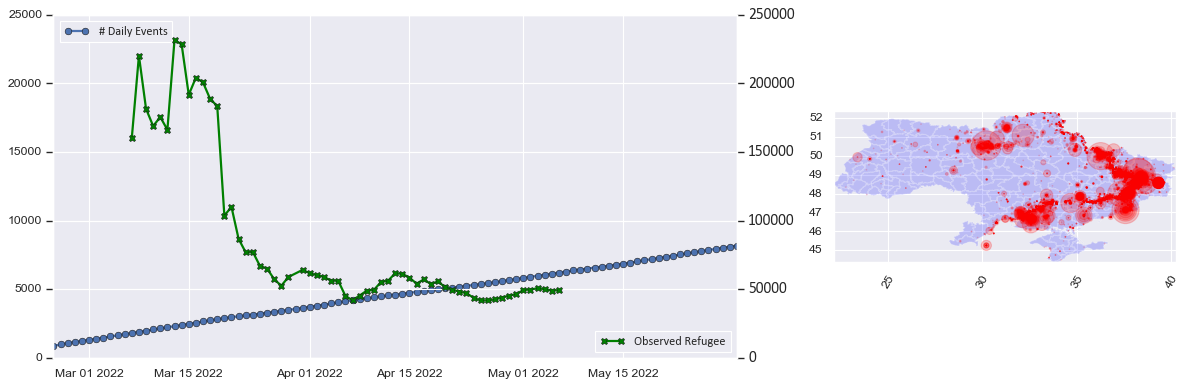

In [3]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [4]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [5]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [6]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [7]:
r1 = get_raion_list(99950,prefix='mim_result')
r2 = get_raion_list(500,prefix='mim_result')
r1-r2

{'Berehivskyi',
 'Chortkivskyi',
 'Kovelskyi',
 'Krasnohvardiiskyi',
 'Krasnoperekopskyi',
 'Rozdilnianskyi',
 'Tiachivskyi',
 'Yaltynskyi'}

In [8]:
# HOUSEHOLD_DATA_PREFIX = 'ukraine_household_data_ADM2_HDX.csv'
# hh_df = pd.read_csv(HOUSEHOLD_DIR+HOUSEHOLD_DATA_PREFIX)
# hh_df.shape

In [9]:
# hh_cnt = hh_df['matching_place_id'].value_counts().reset_index().rename(columns={'index':'raion','matching_place_id':'hh'})

In [10]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3

#simulation_indices = [10060,10061,10062,10063,10064,10065,10066,10067,10068,10069]
#simulation_indices = [30000,30001,30002,30003,30004,30005,30006]
#simulation_indices = [40000,40001,40002,40003,40004,40005,40006]
#simulation_indices = [50000,50001,50002,50003,50004,50005,50006]
#simulation_indices = [50006,50007,50008,50009,50010,50011]
#simulation_indices = [2000,2001,2004,2005]


In [12]:
import json

samples = []
with open('./logs/bayes_examples_all_log_revised.json', 'r') as file:
    for line in file:
        samples.append(json.loads(line))

good = []
max_err = -50000

for i in range(0,len(samples)):
    tt = samples[i]['target']
    if tt>max_err:
        good.append(i)
print(good)

[4, 5, 7, 11, 12, 13, 14, 15, 20, 22, 28, 30, 31, 35, 37, 39, 41, 42, 47, 49, 53, 54, 55, 56, 58, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72]


In [13]:
good_att = [0, 1, 2, 3, 4, 5, 6, 8, 9]

In [14]:
good_all = [20, 22, 23, 24, 25, 26, 28, 31, 32, 37, 38, 45, 49, 50, 52, 56, 57, 59, 60, 61, 65, 66, 68, 69, 70, 72, 74, 78, 81, 89, 90, 91, 94, 96, 99, 100, 101, 104, 106, 109, 110, 116, 119, 121, 123, 124, 126, 127, 129, 134, 136, 137, 140, 142, 143, 147, 148, 149, 152, 155, 157, 159, 160, 163, 165, 166, 169, 179, 180, 185, 188, 189, 192, 193, 194, 195, 196, 198]
good_all = [26, 28, 31, 45, 49, 50, 52, 59, 61, 65, 69, 74, 99, 101, 104, 109, 142, 159, 160, 185, 188, 189, 194]

In [15]:
import warnings
warnings.filterwarnings('ignore')

simulation_indices_att_pbc = [2000+i for i in good]

first_df = []

for vv in simulation_indices_att_pbc:
    try:
        print(vv,end=' ')
        #current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=15,scale_1=0.8,scale_2=1.25)
        current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=20,scale_1=1.0,scale_2=1.0)
        current_df['comb'] = str(vv)
        first_df.append(current_df)
    except:
        continue

first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

2004 113 raions found
2005 113 raions found
2007 113 raions found
2011 113 raions found
2012 113 raions found
2013 112 raions found
2014 112 raions found
2015 112 raions found
2020 112 raions found
2022 112 raions found
2028 112 raions found
2030 113 raions found
2031 113 raions found
2035 112 raions found
2037 112 raions found
2039 112 raions found
2041 112 raions found
2042 112 raions found
2047 112 raions found
2049 112 raions found
2053 112 raions found
2054 112 raions found
2055 112 raions found
2056 112 raions found
2058 112 raions found
2061 112 raions found
2063 112 raions found
2064 112 raions found
2065 112 raions found
2066 112 raions found
2067 112 raions found
2068 112 raions found
2070 112 raions found
2071 112 raions found
2072 112 raions found


In [16]:
first_df

comb,time,2004,2005,2007,2011,2012,2013,2014,2015,2020,...,2061,2063,2064,2065,2066,2067,2068,2070,2071,2072
0,2022-03-02,31321.857143,28957.714286,29459.857143,35498.714286,30494.142857,28031.000000,28987.285714,25383.000000,24369.428571,...,41818.285714,24846.285714,28948.142857,36467.000000,40244.857143,23528.000000,37010.000000,37702.571429,34368.428571,34609.714286
1,2022-03-03,37341.285714,38036.571429,38282.428571,45764.142857,36620.285714,42079.285714,42949.857143,37920.285714,29599.428571,...,55219.142857,34782.285714,39126.000000,46939.142857,52358.285714,29371.285714,45704.285714,48749.428571,44320.285714,44603.571429
2,2022-03-04,45505.714286,49735.285714,50047.571429,54512.857143,44974.000000,52360.714286,53261.285714,47134.285714,32843.857143,...,67891.142857,45274.571429,46975.428571,56066.285714,63024.857143,37304.571429,55679.857143,58591.285714,52941.571429,52988.285714
3,2022-03-05,51497.142857,59519.714286,60036.857143,65466.000000,50372.428571,62757.285714,63999.000000,56827.714286,40855.428571,...,82995.857143,58026.142857,57539.857143,67533.142857,77367.285714,43032.857143,61490.142857,71196.285714,63679.285714,63623.000000
4,2022-03-06,65219.571429,71114.285714,71762.285714,72937.571429,64358.000000,70193.428571,71537.571429,63692.857143,53276.428571,...,95834.285714,69856.142857,66491.000000,75598.000000,88514.142857,57929.571429,84763.857143,80539.428571,70736.714286,70668.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2022-05-30,7492.571429,10826.142857,10873.857143,9254.142857,8225.428571,10587.000000,10683.285714,10371.571429,9756.142857,...,5720.000000,5921.571429,6335.857143,9224.857143,7357.428571,7662.285714,6576.857143,8155.000000,9364.285714,9339.714286
90,2022-05-31,6994.714286,9170.857143,9286.285714,7405.857143,7367.571429,10687.000000,10785.000000,10489.714286,9723.000000,...,5473.285714,5288.142857,5800.000000,7402.428571,6669.857143,6192.714286,6239.571429,7063.428571,7500.142857,7468.000000
91,2022-06-01,7069.857143,7523.571429,7559.428571,6326.857143,7640.142857,9021.857143,9233.857143,9246.571429,9505.857143,...,5300.714286,4754.142857,5608.714286,6285.571429,6159.142857,6738.428571,6309.285714,6365.000000,6305.857143,6328.142857
92,2022-06-02,6612.000000,6483.285714,6437.428571,6908.428571,7192.571429,7216.000000,7473.857143,7679.428571,9037.142857,...,5357.142857,5037.714286,5385.714286,6833.571429,6186.142857,6077.285714,6057.857143,6581.857143,6883.714286,6884.714286


In [17]:
import warnings
warnings.filterwarnings('ignore')

simulation_indices_att = [1000+i for i in good_att]

second_df = []

for vv in simulation_indices_att:
    try:
        print(vv,end=' ')
        #current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=15,scale_1=0.8,scale_2=1.25)
        current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=20,scale_1=1.2,scale_2=1.5)
        current_df['comb'] = str(vv)
        second_df.append(current_df)
    except:
        continue

second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

1000 112 raions found
1001 113 raions found
1002 113 raions found
1003 113 raions found
1004 113 raions found
1005 113 raions found
1006 113 raions found
1008 113 raions found
1009 113 raions found


In [18]:
second_df

comb,time,1000,1001,1002,1003,1004,1005,1006,1008,1009
0,2022-03-02,144013.028571,63628.628571,47099.142857,66904.285714,49753.885714,48323.657143,63537.600000,63732.000000,64359.085714
1,2022-03-03,161194.971429,64277.485714,52074.685714,67846.628571,51123.085714,49397.828571,64216.457143,64374.171429,65084.571429
2,2022-03-04,185069.657143,64544.400000,63610.628571,68404.114286,52960.285714,51677.657143,65302.285714,64564.114286,65166.514286
3,2022-03-05,216228.342857,93369.600000,96954.685714,97939.028571,81037.028571,77618.914286,93393.085714,93503.314286,94329.600000
4,2022-03-06,243190.628571,118114.457143,129765.257143,122709.942857,107816.057143,102802.628571,118161.257143,118193.142857,118952.914286
...,...,...,...,...,...,...,...,...,...,...
89,2022-05-30,33694.500000,16743.214286,20554.500000,20776.071429,16739.357143,17956.928571,18043.928571,17704.714286,16717.928571
90,2022-05-31,31074.857143,16885.285714,20551.928571,20793.428571,16798.928571,17946.000000,18677.357143,17884.714286,17039.785714
91,2022-06-01,28669.071429,16246.071429,19971.214286,20061.214286,16182.428571,17399.142857,18192.857143,17233.285714,16515.428571
92,2022-06-02,29859.000000,17299.071429,21088.071429,22053.428571,17151.857143,18274.714286,19275.428571,18257.142857,17484.642857


In [38]:
good_all = [20, 22, 23, 24, 25, 26, 28, 31, 32, 37, 38, 45, 49, 50, 52, 56, 57, 59, 60, 61, 65, 66, 68, 69, 70, 72, 74, 78, 81, 89, 90, 91, 94, 96, 99, 100, 101, 104, 106, 109, 110, 116, 119, 121, 123, 124, 126, 127, 129, 134, 136, 137, 140, 142, 143, 147, 148, 149, 152, 155, 157, 159, 160, 163, 165, 166, 169, 179, 180, 185, 188, 189, 192, 193, 194, 195, 196, 198]

In [39]:
import warnings
warnings.filterwarnings('ignore')

simulation_indices = [5000+i for i in good_all]

final_df = []

for vv in simulation_indices:
    try:
        print(vv,end=' ')
        #current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=15,scale_1=0.8,scale_2=1.25)
        current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=20,scale_1=1.2,scale_2=1.5)
        current_df['comb'] = str(vv)
        final_df.append(current_df)
    except:
        continue

final_df = pd.concat(final_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

5020 112 raions found
5022 112 raions found
5023 112 raions found
5024 112 raions found
5025 112 raions found
5026 112 raions found
5028 112 raions found
5031 112 raions found
5032 112 raions found
5037 112 raions found
5038 112 raions found
5045 113 raions found
5049 112 raions found
5050 112 raions found
5052 112 raions found
5056 112 raions found
5057 112 raions found
5059 112 raions found
5060 112 raions found
5061 112 raions found
5065 112 raions found
5066 112 raions found
5068 112 raions found
5069 112 raions found
5070 113 raions found
5072 112 raions found
5074 112 raions found
5078 112 raions found
5081 112 raions found
5089 112 raions found
5090 112 raions found
5091 112 raions found
5094 113 raions found
5096 112 raions found
5099 112 raions found
5100 112 raions found
5101 112 raions found
5104 112 raions found
5106 112 raions found
5109 112 raions found
5110 112 raions found
5116 112 raions found
5119 112 raions found
5121 112 raions found
5123 112 raions found
5124 112 r

In [20]:
refugee_data_2 = pd.read_csv('../ABM_model_Ukraine/ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
refugee_data_2 = refugee_data_2[refugee_data_2.time>pd.to_datetime('2022-05-05')]
refugee_data_2.at[71, 'refugee'] = 49355.571429

In [21]:
refugee_data_full = pd.read_csv('ukr_refugee_full.csv')
refugee_data_full['refugee'] = refugee_data_full['Cumulative Refugees'].diff()
refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
refugee_data_full['time'] = pd.to_datetime(refugee_data_full['Date'])
refugee_data_full = refugee_data_full.sort_values(by='time')
refugee_data_full['refugee'] = refugee_data_full['refugee'].rolling(ROLLING).mean()
refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
#refugee_data_full
# refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
# refugee_data_2 = refugee_data_2.sort_values(by='time')
# refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
# refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# # refugee_data['refugee'] = refugee_data['refugee'].diff()
# # refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data_2

## Do specifying different cores and memory change result apart from stochasticity?

In [22]:
refugee_data['refugee'].sum()

5160175.142857144

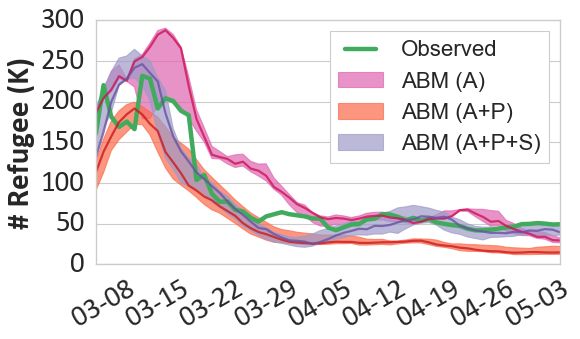

In [81]:
import datetime

trim = 7

#good = []

median_att_pbc,q1_att_pbc,q3_att_pbc = get_uncertainty(simulation_indices_att_pbc,first_df,q1=0.25,q3=0.75)
median_att,q1_att,q3_att = get_uncertainty(simulation_indices_att,second_df,q1=0.25,q3=0.75)
median_all,q1_all,q3_all = get_uncertainty(simulation_indices,final_df,q1=0.35,q3=0.65)

import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(8,5))
plt.xticks(rotation=30)

ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=4,color='#2ca25f')


sns.set_style('white')
ax.plot(second_df['time'][0:-1],median_att.shift(-1)[0:-1]/1000,linewidth=2,color='#ce1256',alpha=0.8)
ax.fill_between(second_df["time"][0:-1], q1_att.shift(-1)[0:-1]/1000, q3_att.shift(-1)[0:-1]/1000, color='#df65b0',alpha=0.7,label='ABM (A)')

ax.plot(first_df['time'][0:-1],median_att_pbc.shift(-1)[0:-1]/1000,linewidth=2,color='#cb181d',alpha=0.8)
ax.fill_between(first_df["time"][0:-1], q1_att_pbc.shift(-1)[0:-1]/1000, q3_att_pbc.shift(-1)[0:-1]/1000, color='#fb6a4a',alpha=0.7,label='ABM (A+P)')

ax.plot(final_df['time'][0:-1],median_all.shift(-1)[0:-1]/1000,linewidth=2,color='#6a51a3',alpha=0.8)
ax.fill_between(final_df["time"][0:-2], q1_all.shift(-2)[0:-2]/1000, q3_all.shift(-2)[0:-2]/1000, color='#9e9ac8',alpha=0.7,label='ABM (A+P+S)')

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=20)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
ax.set_ylim([0,300])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
fig.savefig('../Figures/iaai_abm_ablation.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

In [69]:
final_df['median'] = median_all
final_df['q1'] = q1_all
final_df['q3'] = q3_all

compare_df = final_df.merge(refugee_data,on='time',how='inner')

In [71]:
compare_df['median'] = compare_df['median'].shift(-1)
compare_df['q1'] = compare_df['q1'].shift(-1)
compare_df['q3'] = compare_df['median'].shift(-1)
for pp in simulation_indices:
    compare_df[str(pp)] = compare_df[str(pp)].shift(-1)
compare_df = compare_df.dropna(subset=['median'])

In [72]:
pcc = compare_df['median'].corr(compare_df['refugee'])
print(pcc)
mse = (((compare_df['median'] - compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(mse)

0.9217514179182144
26181.159519078723


In [73]:
all_pccs = []
for pp in simulation_indices:
    pcc = compare_df[str(pp)].corr(compare_df['refugee'])
    #print(pcc)
    
    all_pccs.append(pcc)

In [74]:
all_mses = []
for pp in simulation_indices:
    mse = (((compare_df[str(pp)] - compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
    #print(mse)
    #if mse<32000:
    all_mses.append(mse)

In [60]:
all_mses

[53237.01893586857,
 39741.19694530288,
 39720.985733006535,
 37800.515567473136,
 50413.45711759311,
 25706.317342267437,
 37085.555129749446,
 37041.389560309595,
 45935.61536476913]

In [75]:
print(sum(all_mses)/len(all_mses),np.std(all_mses))
print(sum(all_pccs)/len(all_pccs),np.std(all_pccs))

41687.279097488536 10717.678907828586
0.8515774450083543 0.07405136594673967


In [52]:
np.std(all_mses)

4891.797887415989

In [78]:
data = {'Composition': ['A', 'A+P', 'A+P+S'],
        'MSE': ['40742.45+7749.33', '37447.65 + 4891.8', '26000.035 + 1301.92'],
        'PCC': ['0.91 + 0.06', '0.91 + 0.05', '0.91 + 0.01']}
df = pd.DataFrame(data)

In [79]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} & Composition &                  MSE &          PCC \\
\midrule
0 &           A &     40742.45+7749.33 &  0.91 + 0.06 \\
1 &         A+P &    37447.65 + 4891.8 &  0.91 + 0.05 \\
2 &       A+P+S &  26000.035 + 1301.92 &  0.91 + 0.01 \\
\bottomrule
\end{tabular}



In [ ]:
(compare_df['median']-compare_df['refugee'])

In [61]:
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3'].sum()
compare_df['q1'].sum()
compare_df['q3'].sum()

3400824.6428571427

## Compare with food prices

In [73]:
# food_df = pd.read_csv(UNCLEANED_DATA_DIR+'wfp_food_prices_ukr.csv')
# #food_df['commodity'].unique().tolist()
# food_df['date'] = pd.to_datetime(food_df['date'])

# for food in food_df['commodity'].unique().tolist():
#     cur_food_price = food_df[food_df.commodity==food]
    

## compare_everything

In [75]:
x = 7275283.098597599
y = 5523150.002945037
z = 1616600.5681473766
a = 10305552.99151849
b = 7887347.678246012
c = 2202283.6001177765

In [76]:
x_axis = ['Overall','March','April']
Method = ['Observed','ABM','Pandey']
colors = ['#41ab5d','#6a51a3','#ae017e']
values = [[5160175,3321159,1540624],[4917812,3400824,1266664],[8519858,6484278,1881154]]
errmin = [[0,0,0],[values[1][0]-3990658,values[1][1]-2878165,values[1][2]-907943],[values[2][0]-x,values[2][1]-y,values[2][2]-z]]
errmax = [[0,0,0],[6137919-values[1][0],4123093-values[1][1],1711786-values[1][2]],[a-values[2][0],b-values[2][1],c-values[2][2]]]

In [77]:
print(errmin)
print(errmax)

[[0, 0, 0], [927154, 522659, 358721], [1244574.9014024008, 961127.9970549634, 264553.43185262335]]
[[0, 0, 0], [1220107, 722269, 445122], [1785694.99151849, 1403069.678246012, 321129.60011777654]]


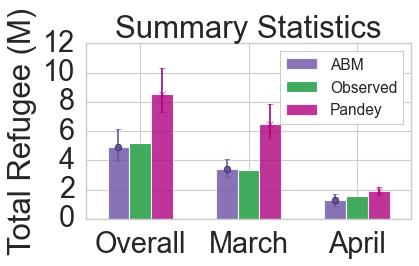

In [105]:
# Numbers of pairs of bars you want
N = len(x_axis)

truth_bar = values[0]
abm_bar = values[1]
pandey_bar = values[2]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig,ax = plt.subplots(figsize=(6,4))

# Width of a bar 
width = 0.2       

# Plotting
ax.bar(ind - width, np.array(abm_bar)/1e6 , width, label='ABM',color=colors[1],alpha=0.8)
ax.errorbar(ind - width, np.array(abm_bar)/1e6, yerr = [np.array(errmin[1])/1e6,np.array(errmax[1])/1e6],fmt='o',color=colors[1])

ax.bar(ind, np.array(truth_bar)/1e6 , width, label='Observed',color=colors[0])

ax.bar(ind + width, np.array(pandey_bar)/1e6 , width, label='Pandey',color=colors[2],alpha=0.8)
ax.errorbar(ind + width, np.array(pandey_bar)/1e6, yerr = [np.array(errmin[2])/1e6,np.array(errmax[2])/1e6],fmt='x',color=colors[2])

ax.set_ylabel('Total Refugee (M)')

ax.set_title('Summary Statistics')

ax.set_xticks(ind)
ax.set_xticklabels(x_axis)
ax.set_yticks
# Finding the best position for legends and putting it
ax.legend(loc='best',fontsize=14,ncol=1)
ax.set_ylim([0,12])
fig.tight_layout()
fig.savefig('../Figures/summary_stat.pdf',dpi=350,bbox_inches='tight')

In [93]:
[errmin[1],errmax[1]]

[[927154, 522659, 358721], [1220107, 722269, 445122]]

In [81]:
np.array(abm_bar)/1e6

array([4.917812, 3.400824, 1.266664])

In [51]:
all_dfs = []
for region in all_ids:
    print(region,end=' ')
    try:
        cur_df = get_results_for_2(5000+101, who='refugee',region_name=[region],prefix='mim_result',partition = 20,scale_1 = 1.2,scale_2 = 1.5)
        cur_df['raion'] = region
        all_dfs.append(cur_df)
        #break
    except:
        print('chesta')
        continue

Bakhchysaraiskyi 1 raions found
Bilohirskyi 1 raions found
Dzhankoiskyi 1 raions found
Yevpatoriiskyi 1 raions found
Kerchynskyi 1 raions found
Krasnohvardiiskyi chesta
Krasnoperekopskyi chesta
Simferopolskyi 1 raions found
Feodosiiskyi 1 raions found
Yaltynskyi chesta
Vinnytskyi 1 raions found
Haisynskyi chesta
Zhmerynskyi 1 raions found
Mohyliv-Podilskyi chesta
Tulchynskyi chesta
Khmilnytskyi 1 raions found
Volodymyrskyi 1 raions found
Kamin-Kashyrskyi 1 raions found
Kovelskyi chesta
Lutskyi 1 raions found
Dniprovskyi 1 raions found
Kamianskyi 1 raions found
Kryvorizkyi 1 raions found
Nikopolskyi 1 raions found
Novomoskovskyi 1 raions found
Pavlohradskyi 1 raions found
Synelnykivskyi 1 raions found
Bakhmutskyi 1 raions found
Volnovaskyi 1 raions found
Horlivskyi 1 raions found
Donetskyi 1 raions found
Kalmiuskyi 1 raions found
Kramatorskyi 1 raions found
Mariupolskyi 1 raions found
Pokrovskyi 1 raions found
Berdychivskyi 1 raions found
Zhytomyrskyi 1 raions found
Korostenskyi 1 raion

In [53]:
pivot_df = pd.concat(all_dfs).pivot(index='raion',columns='time',values='refugee')
each_day_max_raion = pivot_df.idxmax().reset_index()

In [55]:
each_day_max_raion[0].value_counts()

Zaporizkyi      32
Kramatorskyi    12
Alchevskyi       8
Kyiv             8
Kryvorizkyi      8
Chuhuivskyi      7
Kharkivskyi      7
Mykolaivskyi     5
Khersonskyi      5
Donetskyi        2
Name: 0, dtype: int64

In [99]:
def assign_raion_to_dest(hyper_comb, raion, who='refugee',prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 1.2,scale_2 = 1.5):
    all_dfs = []
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    #print(f_name)
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name

    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    all_dfs.append(cur_df)
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(ovr_df[who].sum(),end=' ')
    #dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_stock_only_'+str(raion)+'.csv')
    dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_stock_only_eu_only_'+str(raion)+'.csv')
    ovr_df['key'] = 1
    dest_df['key'] = 1
    raion_to_dest = ovr_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
    raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
    print(raion_to_dest['flow'].sum(),raion)
    raion_to_dest['from'] = raion
    return raion_to_dest

In [100]:
all_dests = []

for raion in all_ids:
    try:
        dest_raion_df = assign_raion_to_dest(5000+101,raion,prefix='mim_result')
        all_dests.append(dest_raion_df)
    except:
        continue

1337.485714285715 1337.485714285715 Bakhchysaraiskyi
26.4 26.4 Bilohirskyi
150.9 150.9 Dzhankoiskyi
165.59999999999997 165.59999999999997 Yevpatoriiskyi
277.5 277.5 Kerchynskyi
3431.0999999999995 3431.1 Simferopolskyi
120.0 120.0 Feodosiiskyi
16826.571428571435 16826.571428571428 Vinnytskyi
1351.5 1351.4999999999998 Zhmerynskyi
328.5 328.49999999999994 Khmilnytskyi
152.4 152.39999999999998 Volodymyrskyi
10.799999999999999 10.799999999999997 Kamin-Kashyrskyi
6888.3 6888.3 Lutskyi
63215.74285714286 63215.74285714286 Dniprovskyi
265.2 265.2 Kamianskyi
375983.9142857143 375983.91428571433 Kryvorizkyi
18583.842857142852 18583.842857142856 Nikopolskyi
477.0 477.0 Novomoskovskyi
3105.814285714286 3105.8142857142866 Pavlohradskyi
1775.0571428571427 1775.057142857143 Synelnykivskyi
68638.28571428574 68638.28571428575 Bakhmutskyi
72995.87142857142 72995.87142857145 Volnovaskyi
263723.3999999996 263723.3999999997 Horlivskyi
505756.41428571334 505756.41428571334 Donetskyi
63817.45714285707 63817.4

In [101]:
all_flow_from_all_raion = pd.concat(all_dests)
all_flow_from_all_raion.groupby('Country')['flow'].sum().reset_index().sort_values(by='flow',ascending=False)

,Country,flow
19,Poland,1.950578e+06
14,Italy,9.055663e+05
10,Germany,7.335411e+05
5,Czech Republic,5.643315e+05
12,Hungary,3.730222e+05
21,Romania,3.225132e+05
24,Spain,2.221435e+05
11,Greece,1.927058e+05
7,Estonia,1.826178e+05
2,Bulgaria,1.458914e+05


In [85]:
raion_df = get_results_for_2(5000+101,region_name=['Kyiv'],prefix='mim_result')
print(raion_df['refugee'].sum())
dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_'+str('Kyiv')+'.csv')
dest_df['rij'].sum()
raion_df['key'] = 1
dest_df['key'] = 1
raion_to_dest = raion_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
print(raion_to_dest['flow'].sum())

1 raions found
358943.28571428574
357090.9346861782


## For IDP with Map


In [115]:
simulation_indices

[5026,
 5028,
 5031,
 5045,
 5049,
 5050,
 5052,
 5059,
 5061,
 5065,
 5069,
 5074,
 5099,
 5101,
 5104,
 5109,
 5142,
 5159,
 5160,
 5185,
 5188,
 5189,
 5194]

## Round 3 -  5194

In [132]:
%%time
from file_paths_and_consts import *
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

ukr_gdf_adm2 = gpd.read_file(UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp')
ukr_gdf_adm2_trimmed = ukr_gdf_adm2[['ADM2_EN','geometry']]

latest_date = pd.to_datetime('2022-04-17')

for idx in [5194]:
    print(idx)

    all_dfs = pd.concat(get_uncertainty_results(idx,prefix='mim')).reset_index()
    all_dfs = all_dfs[all_dfs.time<=latest_date]
    pivot_df = all_dfs.pivot(index='id',columns='time',values='refugee').fillna(0)
    pivot_df['Total'] = (pivot_df[pivot_df.columns.tolist()].sum(axis = 1))
    raion_with_count_df = gpd.GeoDataFrame(pivot_df[['Total']].reset_index().rename(columns={'id':'ADM2_EN'}).merge(ukr_gdf_adm2_trimmed,on='ADM2_EN',how='right').fillna(0))

    ukr_gdf_adm1 = ukr_gdf_adm2.dissolve(by='ADM1_EN')
    ukr_gdf_adm1_trimmed  = ukr_gdf_adm1[['geometry']].reset_index()
    #ukr_gdf_adm1_trimmed

    oblast_with_raion_count_df = raion_with_count_df[['ADM2_EN','Total']].merge(ukr_gdf_adm2[['ADM2_EN','ADM1_EN']],on='ADM2_EN',how='inner').groupby('ADM1_EN')['Total'].sum().reset_index()
    oblast_with_count_df = gpd.GeoDataFrame(oblast_with_raion_count_df.merge(ukr_gdf_adm1_trimmed,on='ADM1_EN',how='inner'))

    oblast_with_count_df['percentage'] = (oblast_with_count_df['Total']/oblast_with_count_df['Total'].sum())*100
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(5)['ADM1_EN'].tolist())
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(5)['percentage'].tolist())

5194
['Donetska', 'Kyiv', 'Kharkivska', 'Luhanska', 'Kyivska']
[29.75400910638947, 17.05285019313287, 13.714798187542415, 10.614633416033408, 5.236188454040529]
CPU times: user 4.28 s, sys: 18.9 ms, total: 4.3 s
Wall time: 4.51 s


## pandey

In [137]:
%%time
from file_paths_and_consts import *
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

ukr_gdf_adm2 = gpd.read_file(UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp')
ukr_gdf_adm2_trimmed = ukr_gdf_adm2[['ADM2_EN','geometry']]

latest_date = pd.to_datetime('2022-03-16')

for idx in [80009]:
    print(idx)

    all_dfs = pd.concat(get_uncertainty_results(idx,prefix='mim')).reset_index()
    all_dfs = all_dfs[all_dfs.time<=latest_date]
    pivot_df = all_dfs.pivot(index='id',columns='time',values='refugee').fillna(0)
    pivot_df['Total'] = (pivot_df[pivot_df.columns.tolist()].sum(axis = 1))
    raion_with_count_df = gpd.GeoDataFrame(pivot_df[['Total']].reset_index().rename(columns={'id':'ADM2_EN'}).merge(ukr_gdf_adm2_trimmed,on='ADM2_EN',how='right').fillna(0))

    ukr_gdf_adm1 = ukr_gdf_adm2.dissolve(by='ADM1_EN')
    ukr_gdf_adm1_trimmed  = ukr_gdf_adm1[['geometry']].reset_index()
    #ukr_gdf_adm1_trimmed

    oblast_with_raion_count_df = raion_with_count_df[['ADM2_EN','Total']].merge(ukr_gdf_adm2[['ADM2_EN','ADM1_EN']],on='ADM2_EN',how='inner').groupby('ADM1_EN')['Total'].sum().reset_index()
    oblast_with_count_df = gpd.GeoDataFrame(oblast_with_raion_count_df.merge(ukr_gdf_adm1_trimmed,on='ADM1_EN',how='inner'))

    oblast_with_count_df['percentage'] = (oblast_with_count_df['Total']/oblast_with_count_df['Total'].sum())*100
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(5)['ADM1_EN'].tolist())
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(5)['percentage'].tolist())

80009
['Kyiv', 'Luhanska', 'Kyivska', 'Kharkivska', 'Odeska']
[16.363559964524804, 11.660146192138239, 10.535185529553127, 8.4001473364994, 7.773788407621446]
CPU times: user 4.29 s, sys: 23 ms, total: 4.32 s
Wall time: 4.99 s


## Round 4

In [131]:
# %%time
# from file_paths_and_consts import *
# import pandas as pd
# import geopandas as gpd
# import warnings
# warnings.filterwarnings('ignore')

# ukr_gdf_adm2 = gpd.read_file(UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp')
# ukr_gdf_adm2_trimmed = ukr_gdf_adm2[['ADM2_EN','geometry']]

# latest_date = pd.to_datetime('2022-05-03')
# earliest_date = pd.to_datetime('2022-04-17')
# for idx in simulation_indices:
#     print(idx)

#     all_dfs = pd.concat(get_uncertainty_results(idx,prefix='mim')).reset_index()
#     all_dfs = all_dfs[all_dfs.time<=latest_date]
#     #all_dfs = all_dfs[all_dfs.time>=earliest_date]
#     pivot_df = all_dfs.pivot(index='id',columns='time',values='refugee').fillna(0)
#     pivot_df['Total'] = (pivot_df[pivot_df.columns.tolist()].sum(axis = 1))
#     raion_with_count_df = gpd.GeoDataFrame(pivot_df[['Total']].reset_index().rename(columns={'id':'ADM2_EN'}).merge(ukr_gdf_adm2_trimmed,on='ADM2_EN',how='right').fillna(0))

#     ukr_gdf_adm1 = ukr_gdf_adm2.dissolve(by='ADM1_EN')
#     ukr_gdf_adm1_trimmed  = ukr_gdf_adm1[['geometry']].reset_index()
#     #ukr_gdf_adm1_trimmed

#     oblast_with_raion_count_df = raion_with_count_df[['ADM2_EN','Total']].merge(ukr_gdf_adm2[['ADM2_EN','ADM1_EN']],on='ADM2_EN',how='inner').groupby('ADM1_EN')['Total'].sum().reset_index()
#     oblast_with_count_df = gpd.GeoDataFrame(oblast_with_raion_count_df.merge(ukr_gdf_adm1_trimmed,on='ADM1_EN',how='inner'))

#     oblast_with_count_df['percentage'] = (oblast_with_count_df['Total']/oblast_with_count_df['Total'].sum())*100
#     print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(10)['ADM1_EN'].tolist())
#     print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(10)['percentage'].tolist())

## Round 2  - 5185- 

In [126]:
%%time
from file_paths_and_consts import *
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

ukr_gdf_adm2 = gpd.read_file(UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp')
ukr_gdf_adm2_trimmed = ukr_gdf_adm2[['ADM2_EN','geometry']]

latest_date = pd.to_datetime('2022-04-01')

for idx in [5185]:
    print(idx)

    all_dfs = pd.concat(get_uncertainty_results(idx,prefix='mim')).reset_index()
    all_dfs = all_dfs[all_dfs.time<=latest_date]
    pivot_df = all_dfs.pivot(index='id',columns='time',values='refugee').fillna(0)
    pivot_df['Total'] = (pivot_df[pivot_df.columns.tolist()].sum(axis = 1))
    raion_with_count_df = gpd.GeoDataFrame(pivot_df[['Total']].reset_index().rename(columns={'id':'ADM2_EN'}).merge(ukr_gdf_adm2_trimmed,on='ADM2_EN',how='right').fillna(0))

    ukr_gdf_adm1 = ukr_gdf_adm2.dissolve(by='ADM1_EN')
    ukr_gdf_adm1_trimmed  = ukr_gdf_adm1[['geometry']].reset_index()
    #ukr_gdf_adm1_trimmed

    oblast_with_raion_count_df = raion_with_count_df[['ADM2_EN','Total']].merge(ukr_gdf_adm2[['ADM2_EN','ADM1_EN']],on='ADM2_EN',how='inner').groupby('ADM1_EN')['Total'].sum().reset_index()
    oblast_with_count_df = gpd.GeoDataFrame(oblast_with_raion_count_df.merge(ukr_gdf_adm1_trimmed,on='ADM1_EN',how='inner'))

    oblast_with_count_df['percentage'] = (oblast_with_count_df['Total']/oblast_with_count_df['Total'].sum())*100
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(10)['ADM1_EN'].tolist())
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(10)['percentage'].tolist())

5185
['Kyiv', 'Donetska', 'Luhanska', 'Kharkivska', 'Chernihivska', 'Kyivska', 'Mykolaivska', 'Sumska', 'Zaporizka', 'Vinnytska']
[36.17750611327357, 31.565252925902353, 11.802770254381247, 7.955272379843546, 4.224859933267884, 3.9765467363259184, 1.5040626341261267, 1.0739545767740004, 0.4837996194723591, 0.31803822707666296]
CPU times: user 4.42 s, sys: 20.8 ms, total: 4.44 s
Wall time: 5.12 s


## Round 1  - 5074- 

In [19]:
%%time
from file_paths_and_consts import *
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

ukr_gdf_adm2 = gpd.read_file(UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp')
ukr_gdf_adm2_trimmed = ukr_gdf_adm2[['ADM2_EN','geometry']]

latest_date = pd.to_datetime('2022-06-03')

for idx in [5020]:
    print(idx)

    all_dfs = pd.concat(get_uncertainty_results(idx,prefix='mim')).reset_index()
    all_dfs = all_dfs[all_dfs.time<=latest_date]
    pivot_df = all_dfs.pivot(index='id',columns='time',values='refugee').fillna(0)
    pivot_df['Total'] = (pivot_df[pivot_df.columns.tolist()].sum(axis = 1))
    raion_with_count_df = gpd.GeoDataFrame(pivot_df[['Total']].reset_index().rename(columns={'id':'ADM2_EN'}).merge(ukr_gdf_adm2_trimmed,on='ADM2_EN',how='right').fillna(0))

    ukr_gdf_adm1 = ukr_gdf_adm2.dissolve(by='ADM1_EN')
    ukr_gdf_adm1_trimmed  = ukr_gdf_adm1[['geometry']].reset_index()
    #ukr_gdf_adm1_trimmed

    oblast_with_raion_count_df = raion_with_count_df[['ADM2_EN','Total']].merge(ukr_gdf_adm2[['ADM2_EN','ADM1_EN']],on='ADM2_EN',how='inner').groupby('ADM1_EN')['Total'].sum().reset_index()
    oblast_with_count_df = gpd.GeoDataFrame(oblast_with_raion_count_df.merge(ukr_gdf_adm1_trimmed,on='ADM1_EN',how='inner'))

    oblast_with_count_df['percentage'] = (oblast_with_count_df['Total']/oblast_with_count_df['Total'].sum())*100
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(10)['ADM1_EN'].tolist())
    print(oblast_with_count_df.sort_values(by='percentage',ascending=False).head(10)['percentage'].tolist())

5020
['Donetska', 'Kyiv', 'Kharkivska', 'Luhanska', 'Zaporizka', 'Kyivska', 'Chernihivska', 'Khersonska', 'Dnipropetrovska', 'Odeska']
[37.72969245995568, 17.9073614382117, 15.770151916962577, 7.6667690019175145, 4.5741100861566695, 3.2897532165637235, 2.9343431730655882, 2.4161649553781555, 2.0838015453753655, 1.7930365667597579]
CPU times: user 4.13 s, sys: 32.8 ms, total: 4.16 s
Wall time: 4.27 s


In [27]:
oblast_with_count_df.sort_values(by='Total',ascending=False).tail(150).head(50)

,ADM1_EN,Total,geometry,percentage
5,Donetska,1779530.0,"POLYGON ((38.84262 47.86676, 38.84233 47.86687...",37.729692
11,Kyiv,844605.0,"POLYGON ((30.73374 50.58799, 30.75192 50.58356...",17.907361
7,Kharkivska,743803.0,"POLYGON ((37.53472 50.33373, 37.53663 50.33337...",15.770152
13,Luhanska,361605.0,"POLYGON ((39.69117 48.58634, 39.69118 48.58634...",7.666769
25,Zaporizka,215739.0,"MULTIPOLYGON (((36.80474 46.70357, 36.80450 46...",4.574110
12,Kyivska,155162.0,"MULTIPOLYGON (((30.92955 49.41855, 30.92929 49...",3.289753
2,Chernihivska,138399.0,"POLYGON ((33.04160 50.99719, 33.04078 50.99644...",2.934343
8,Khersonska,113959.0,"MULTIPOLYGON (((32.55747 46.06686, 32.55777 46...",2.416165
4,Dnipropetrovska,98283.0,"POLYGON ((34.84621 48.01536, 34.84653 48.01361...",2.083802
16,Odeska,84569.0,"MULTIPOLYGON (((30.20662 45.25740, 30.20674 45...",1.793037


## Raion Map

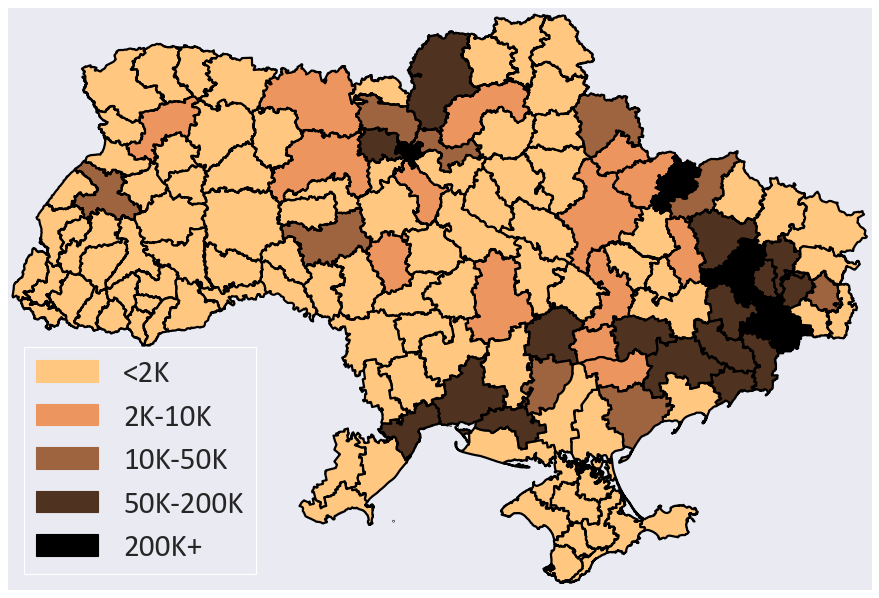

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

raion_with_count_df['coords'] = raion_with_count_df['geometry'].apply(lambda x: x.representative_point().coords[:])
raion_with_count_df['coords'] = [coords[0] for coords in raion_with_count_df['coords']]

# Set the column to use for the choropleth
all_colors = ['#ffc77f', '#ec955f', '#9d643f', '#4f3220', '#000000']
diff_ranges = [(0, 2000), (2000, 10000), (10000, 50000), (50000,200000), (200000,1000000)]
### 0,17112,43169,74445,118438,198192 previously

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'{diff_range[0]//1000}K+')
    elif i==0:
        legend_labels.append(f'<{diff_range[1]//1000}K')
    else:
        legend_labels.append(f'{diff_range[0]//1000}K-{diff_range[1]//1000}K')

#value_column = "hhs"
raion_with_count_df['diff_color'] = raion_with_count_df['Total'].apply(lambda x: diff_to_color(x))
# Create the figure and axis objects
fig,ax = plt.subplots(figsize=(12,8))
#plt.xticks(rotation=30)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
rcParams["axes.labelsize"] = 20
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

# Plot the polygons with the choropleth
#polygons_gdf.plot(column=value_column, cmap=cmap, ax=ax, edgecolor='black',scheme='EqualInterval',legend=True,legend_kwds={'fontsize':20,'loc':'lower left'})
raion_with_count_df.plot(ax=ax,edgecolor='black',color=raion_with_count_df['diff_color'],linewidth=2)

# Add a legend
EPS = 0.1
ax.set_xlim(raion_with_count_df.total_bounds[0]-EPS, raion_with_count_df.total_bounds[2]+EPS)
ax.set_ylim(raion_with_count_df.total_bounds[1]-EPS, raion_with_count_df.total_bounds[3]+EPS)
ax.legend(handles=legend_handles,labels=legend_labels,loc='lower left',fontsize=28)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True,right=True,top=True,bottom=True)

fig.tight_layout()
fig.savefig('../Figures/iaai_raion_migration.png',dpi=350,bbox_inches='tight')

## Oblast Map

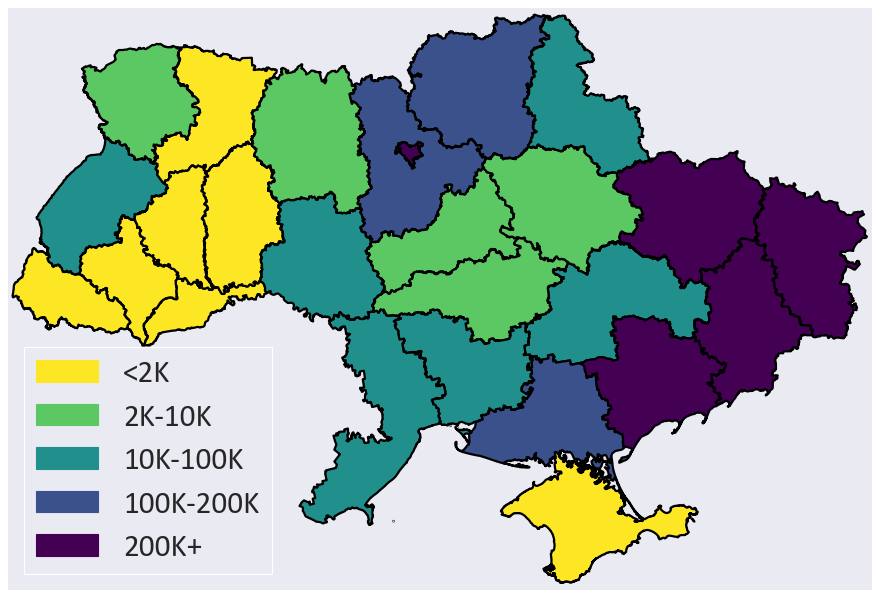

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

oblast_with_count_df['coords'] = oblast_with_count_df['geometry'].apply(lambda x: x.representative_point().coords[:])
oblast_with_count_df['coords'] = [coords[0] for coords in oblast_with_count_df['coords']]

# Set the column to use for the choropleth
all_colors = ['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']
diff_ranges = [(0, 2000), (2000, 10000), (10000, 100000), (100000,200000), (200000,1000000)]
### 0,17112,43169,74445,118438,198192 previously

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'{diff_range[0]//1000}K+')
    elif i==0:
        legend_labels.append(f'<{diff_range[1]//1000}K')
    else:
        legend_labels.append(f'{diff_range[0]//1000}K-{diff_range[1]//1000}K')

#value_column = "hhs"
oblast_with_count_df['diff_color'] = oblast_with_count_df['Total'].apply(lambda x: diff_to_color(x))
# Create the figure and axis objects
fig,ax = plt.subplots(figsize=(12,8))
#plt.xticks(rotation=30)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
rcParams["axes.labelsize"] = 20
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

# Plot the polygons with the choropleth
#polygons_gdf.plot(column=value_column, cmap=cmap, ax=ax, edgecolor='black',scheme='EqualInterval',legend=True,legend_kwds={'fontsize':20,'loc':'lower left'})
oblast_with_count_df.plot(ax=ax,edgecolor='black',color=oblast_with_count_df['diff_color'],linewidth=2)

# Add a legend
EPS = 0.1
ax.set_xlim(oblast_with_count_df.total_bounds[0]-EPS, oblast_with_count_df.total_bounds[2]+EPS)
ax.set_ylim(oblast_with_count_df.total_bounds[1]-EPS, oblast_with_count_df.total_bounds[3]+EPS)
ax.legend(handles=legend_handles,labels=legend_labels,loc='lower left',fontsize=28)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True,right=True,top=True,bottom=True)

fig.tight_layout()
fig.savefig('../Figures/iaai_oblast_migration.png',dpi=350,bbox_inches='tight')

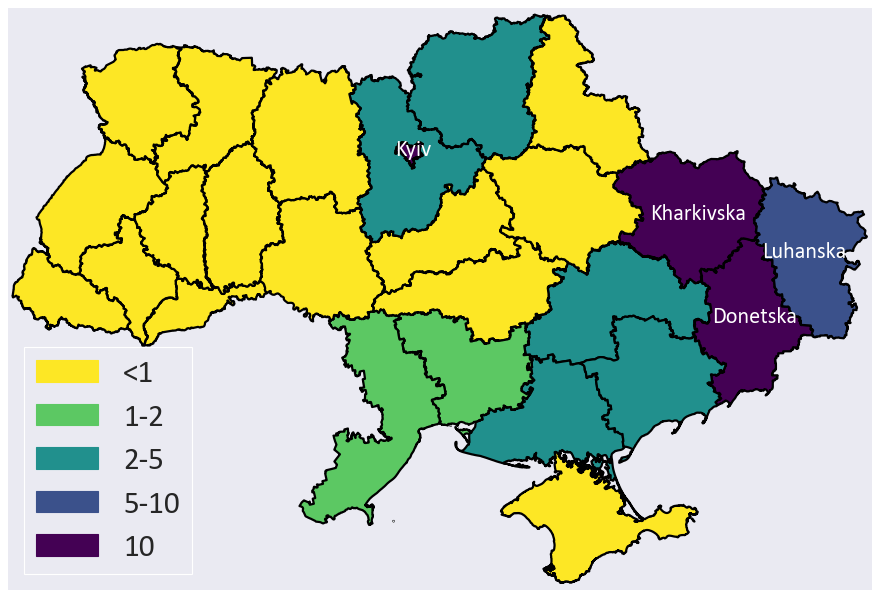

In [32]:
import matplotlib.pyplot as plt

# Set the column to use for the choropleth
all_colors = ['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']
diff_ranges = [(0, 1), (1, 2), (2, 5), (5, 10), (10,100)]
### 0,17112,43169,74445,118438,198192 previously

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'{diff_range[0]}')
    elif i==0:
        legend_labels.append(f'<{diff_range[1]}')
    else:
        legend_labels.append(f'{diff_range[0]}-{diff_range[1]}')

#value_column = "hhs"
oblast_with_count_df['diff_color'] = oblast_with_count_df['percentage'].apply(lambda x: diff_to_color(x))
# Create the figure and axis objects
fig,ax = plt.subplots(figsize=(12,8))
#plt.xticks(rotation=30)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
rcParams["axes.labelsize"] = 20
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

# Plot the polygons with the choropleth
#polygons_gdf.plot(column=value_column, cmap=cmap, ax=ax, edgecolor='black',scheme='EqualInterval',legend=True,legend_kwds={'fontsize':20,'loc':'lower left'})
oblast_with_count_df.plot(ax=ax,edgecolor='black',color=oblast_with_count_df['diff_color'],linewidth=2)

oblast_with_count_df['coords'] = oblast_with_count_df['geometry'].apply(lambda x: x.representative_point().coords[:])
oblast_with_count_df['coords'] = [coords[0] for coords in oblast_with_count_df['coords']]
for idx, row in oblast_with_count_df.iterrows():
    if(row['Total']>250000):
        ax.annotate(s=row['ADM1_EN'], xy=row['coords'],ha='center',fontsize=20,color='#ffffff')

# Add a legend
EPS = 0.1
ax.set_xlim(oblast_with_count_df.total_bounds[0]-EPS, oblast_with_count_df.total_bounds[2]+EPS)
ax.set_ylim(oblast_with_count_df.total_bounds[1]-EPS, oblast_with_count_df.total_bounds[3]+EPS)
ax.legend(handles=legend_handles,labels=legend_labels,loc='lower left',fontsize=28)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True,right=True,top=True,bottom=True)
sns.set_style('white')

fig.tight_layout()
#fig.savefig('../Figures/oblast_migration.png',dpi=350,bbox_inches='tight')